# Fairness Opinion Comparison
+ Aim to directly compare TNIC similarity scores to real fairness opinion comparables
+ Procedure:
    + Load in manually scraped comparable companies
    + Format datasets fit for merging
    + Directly compare comparable companies with pairwise sim. score
    + Identify any patterns that emerge
+ Next Iterations:
    + Expand scope to acquisitions of smaller magnitude
    + Amend existing scraping pipeline
    + Fix TNIC dataset to include all of 

# Load in All Three Datasets

In [269]:

import pandas as pd
import numpy as np

fo = pd.read_csv('top_deals.csv')
gvkey = pd.read_csv('gvkey.csv')
tnic_2023 = pd.read_csv('tnic_2022_2023.csv')

fo.columns = (fo.columns
               .str.strip()
               .str.lower()
               .str.replace(' ', '_'))
gvkey.columns = (gvkey.columns
               .str.strip()
               .str.lower()
               .str.replace(' ', '_'))
tnic_2023.columns = (tnic_2023.columns
                     .str.strip()
                     .str.lower()
                     .str.replace(' ', '_'))

fo.head(30)

,target_name,target_ticker,target_gvkey,year,peer_name,peer_ticker,peer_gvkey,valuation_multiple
0,Pioneer Natural Resources Co.,PXD,12758,2023,APA Corporation,APA,4127,7.4x
1,Pioneer Natural Resources Co.,PXD,12758,2023,Chesapeake Energy Corporation,CHK,2137,5.9x
2,Pioneer Natural Resources Co.,PXD,12758,2023,ConocoPhillips,COP,2477,7.0x
3,Pioneer Natural Resources Co.,PXD,12758,2023,Devon Energy Corporation,DVN,2874,5.6x
4,Pioneer Natural Resources Co.,PXD,12758,2023,EOG Resources Inc.,EOG,3240,6.7x
5,Pioneer Natural Resources Co.,PXD,12758,2023,Hess Corporation,HES,3767,6.9x
6,Hess Corporation,HES,3767,2023,APA Corporation,APA,4127,7.4x
7,Hess Corporation,HES,3767,2023,ConocoPhillips,COP,2477,7.1x
8,Hess Corporation,HES,3767,2023,Devon Energy Corporation,DVN,2874,6.2x
9,Hess Corporation,HES,3767,2023,EOG Resources Inc.,EOG,3240,6.9x


# Data Cleaning

In [270]:

# filter out gvkey df
gvkey = gvkey.drop(columns=['costat', 'curcd', 'datafmt', 'indfmt', 'consol', 'fyrc', 'datadate'])
gvkey = gvkey[gvkey['tic'].notnull()]
print(gvkey.columns)




Index(['gvkey', 'conm', 'tic', 'sic', 'ebitda', 'revt'], dtype='object')


# Merge GVKEY Dataset onto TNIC

In [271]:
gvkey_name_map = gvkey[['gvkey', 'conm', 'tic']]

gvkey_name_map = gvkey_name_map.rename(columns={
    'gvkey': 'gvkey',
    'conm' : 'company_name',
    'tic' : 'ticker'
})

# merge tnic with firm side

tnic_named = tnic_2023.merge(
    gvkey_name_map,
    how='left',
    left_on='gvkey1',
    right_on='gvkey' 
).rename(columns={
    'company_name' : 'firm_name',
    'ticker' : 'firm_ticker'
}).drop('gvkey', axis=1)

# merge tnic with peer side
tnic_named = tnic_named.merge(
    gvkey_name_map, 
    how='left', 
    left_on='gvkey2',
    right_on='gvkey'
).rename(columns={
    'company_name' : 'peer_name',
    'ticker' : 'peer_ticker'
}).drop('gvkey', axis=1)

tnic_named = tnic_named[[
    'year', 'gvkey1', 'firm_name', 'firm_ticker', 'gvkey2', 'peer_name', 'peer_ticker', 'score'
]]

tnic_named.head()

,year,gvkey1,firm_name,firm_ticker,gvkey2,peer_name,peer_ticker,score
0,2022,1004,AAR CORP,AIR,1823,ASTRONICS CORP,ATRO,0.0114
1,2022,1004,AAR CORP,AIR,4091,DUCOMMUN INC,DCO,0.0461
2,2022,1004,AAR CORP,AIR,5608,HEXCEL CORP,HXL,0.0017
3,2022,1004,AAR CORP,AIR,9698,SIFCO INDUSTRIES,SIF,0.0109
4,2022,1004,AAR CORP,AIR,10519,TEXTRON INC,TXT,0.0064


# Feature Engineer Peer Rank 

In [272]:
tnic_named['peer_rank'] = (
    tnic_named.groupby('firm_ticker')['score']
    .rank(method='first', ascending=False)
)
 
n = 10
top_n_peers = tnic_named[tnic_named['peer_rank'] <= n].copy()

# for checking how many peers (comparable companies) per company
peer_counts = top_n_peers.groupby('firm_ticker')['peer_rank'].count()

print(top_n_peers[top_n_peers['firm_ticker'] == 'MSFT'])


         year  gvkey1       firm_name firm_ticker  gvkey2  \
68253    2022   12141  MICROSOFT CORP        MSFT   12540   
68273    2022   12141  MICROSOFT CORP        MSFT   26746   
1299245  2023   12141  MICROSOFT CORP        MSFT   12142   
1299268  2023   12141  MICROSOFT CORP        MSFT   26746   
1299293  2023   12141  MICROSOFT CORP        MSFT   36641   
1299314  2023   12141  MICROSOFT CORP        MSFT   38931   
1299337  2023   12141  MICROSOFT CORP        MSFT   61870   
1299346  2023   12141  MICROSOFT CORP        MSFT  121077   
1299358  2023   12141  MICROSOFT CORP        MSFT  178083   
1299359  2023   12141  MICROSOFT CORP        MSFT  178310   

                      peer_name peer_ticker   score  peer_rank  
68253                 ADOBE INC        ADBE  0.1010        1.0  
68273               NUTANIX INC        NTNX  0.0765        6.0  
1299245             ORACLE CORP        ORCL  0.0778        5.0  
1299268             NUTANIX INC        NTNX  0.0994        2.0  
129

# TNIC Peer Per Company 

+ List of every peer company per acquisition project focuses on:
    + Exxon Mobil Acq. Pioneer Natural Resources ($64.5B)
        + APA Corporation
        + Chesapeake Energy Corporation
        + ConocoPhillips 
        + Devon Energy Corporation
        + EOG Resources Inc.
        + Hess Corporation
    + Chevron Acq. Hess ($53.0B)
        + APA Corporation
        + ConocoPhillips
        + Devon Energy Corporation
        + EOG Resources Inc.
        + Marathon Oil Corporation
        + Occidental Petroleum Corporation
    + Cisco Systems Inc. Acq. Splunk Inc. ($28.0B)
        + Adobe Inc. 
        + Altassian Corp.
        + Autodesk.
        + Box Inc. 
        + DocuSign Inc.
        + Dropbox Inc.
        + Okta Inc.
        + Palo Alto Networks Inc.
        + Salesforce Inc. 
        + Tenable Inc. 
        + Varonis Systems Inc.
        + Workday Inc. 
    +  Kroger Acq. Albertsons ($24.6B)
        + Sprouts Farmers Market Inc.
        + Weis Markets Inc.
        + Ingles Markets Inc.
        + Village Super Market 


# Adapt Time Series Filter to TNIC Dataset


# Feature Engineering Comparable Company Rankings

In [273]:

# rank the comparable companies by valuation multiple
fo['valuation_numeric'] = pd.to_numeric(
    fo['valuation_multiple']
    .str.replace('x', '', regex=False)
    .str.replace('-', '', regex=False),
    errors='coerce'
)
fo['valuation_rank'] = fo['valuation_numeric'].rank(pct=True, na_option='keep')
print(fo.head(25))

                      target_name target_ticker  target_gvkey  year  \
0   Pioneer Natural Resources Co.           PXD         12758  2023   
1   Pioneer Natural Resources Co.           PXD         12758  2023   
2   Pioneer Natural Resources Co.           PXD         12758  2023   
3   Pioneer Natural Resources Co.           PXD         12758  2023   
4   Pioneer Natural Resources Co.           PXD         12758  2023   
5   Pioneer Natural Resources Co.           PXD         12758  2023   
6                Hess Corporation           HES          3767  2023   
7                Hess Corporation           HES          3767  2023   
8                Hess Corporation           HES          3767  2023   
9                Hess Corporation           HES          3767  2023   
10               Hess Corporation           HES          3767  2023   
11               Hess Corporation           HES          3767  2023   
12                    Splunk Inc.          SPLK        153037  2023   
13    

# Visualize Valuation Multiples of Fairness Opinions

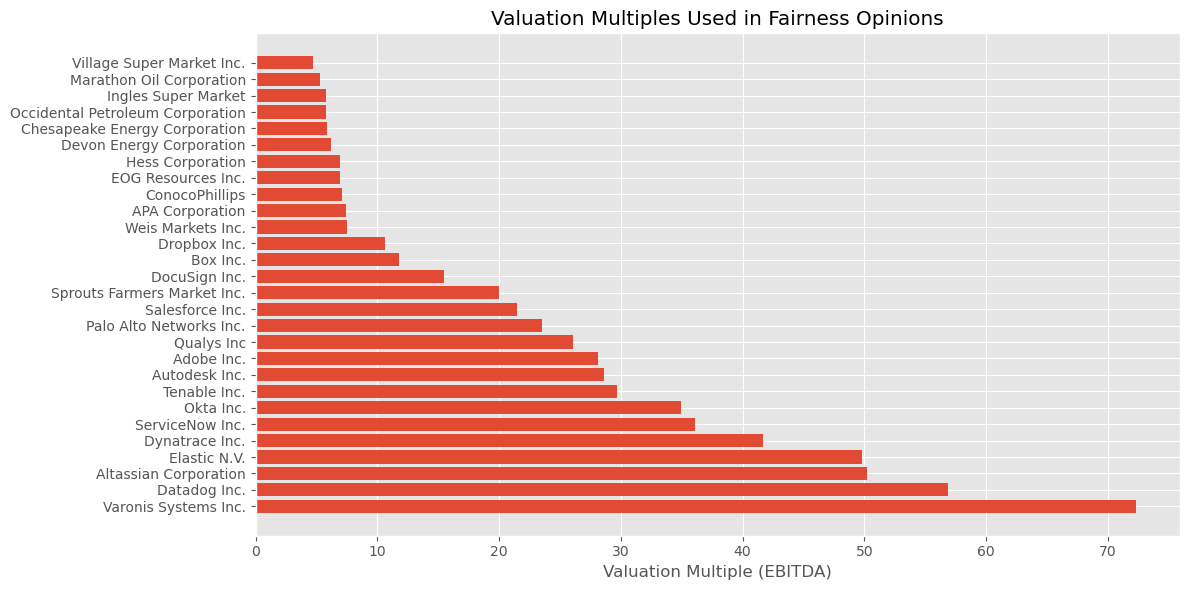

In [274]:
import matplotlib.pyplot as plt

# Assuming `fo` contains cleaned 'peer_name' and 'valuation_numeric'
fo_cleaned = fo[fo['valuation_numeric'].notnull()]

plt.figure(figsize=(12, 6))
fo_cleaned_sorted = fo_cleaned.sort_values(by='valuation_numeric', ascending=False)

plt.barh(fo_cleaned_sorted['peer_name'], fo_cleaned_sorted['valuation_numeric'])
plt.xlabel('Valuation Multiple (EBITDA)')
plt.title('Valuation Multiples Used in Fairness Opinions')
plt.tight_layout()
plt.show()


/var/folders/g1/5jyzgjs54vj6npmtcwwyq7cr0000gn/T/ipykernel_49848/3465927763.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_name', y='valuation_multiple', data=fo, palette='pastel')


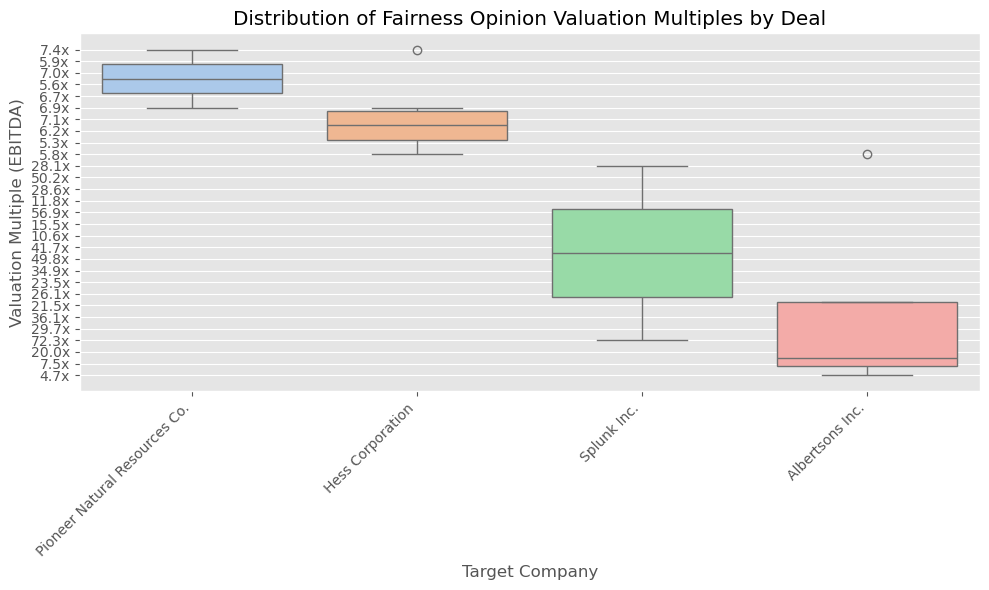

In [281]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='target_name', y='valuation_multiple', data=fo, palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Valuation Multiple (EBITDA)')
plt.xlabel('Target Company')
plt.title('Distribution of Fairness Opinion Valuation Multiples by Deal')
plt.tight_layout()
plt.show()


In [275]:
fo["peer_gvkey"] = fo["peer_gvkey"].astype("Int64")
top_n_peers["gvkey2"] = top_n_peers["gvkey2"].astype("Int64")

merged_df = pd.merge(
    top_n_peers, fo, left_on='firm_ticker', right_on='target_ticker', how='inner'
)
final_df = merged_df.drop_duplicates().copy()

print(final_df.head(22))


    year_x  gvkey1  firm_name firm_ticker  gvkey2        peer_name_x  \
0     2022    1380  HESS CORP         HES    1678           APA CORP   
1     2022    1380  HESS CORP         HES    1678           APA CORP   
2     2022    1380  HESS CORP         HES    1678           APA CORP   
3     2022    1380  HESS CORP         HES    1678           APA CORP   
4     2022    1380  HESS CORP         HES    1678           APA CORP   
5     2022    1380  HESS CORP         HES    1678           APA CORP   
6     2022    1380  HESS CORP         HES    7017  MARATHON OIL CORP   
7     2022    1380  HESS CORP         HES    7017  MARATHON OIL CORP   
8     2022    1380  HESS CORP         HES    7017  MARATHON OIL CORP   
9     2022    1380  HESS CORP         HES    7017  MARATHON OIL CORP   
10    2022    1380  HESS CORP         HES    7017  MARATHON OIL CORP   
11    2022    1380  HESS CORP         HES    7017  MARATHON OIL CORP   
12    2022    1380  HESS CORP         HES   21833  HESS MIDSTREA

In [276]:
# Rank peers for each firm by TNIC score (higher score = closer peer)
tnic_df['tnic_rank'] = tnic_df.groupby('gvkey1')['score'].rank(method='first', ascending=False)

# Merge TNIC rank into peer_df based on gvkey1 (firm) and gvkey2 (peer)
peer_df = peer_df.merge(
    tnic_df[['gvkey1', 'gvkey2', 'tnic_rank']],
    on=['gvkey1', 'gvkey2'],
    how='left'
)



# TNIC List of All Peer Companies

In [277]:

acquirer_firms = ['PXD', 'HES', 'SPLK', 'ACI']
for firm in acquirer_firms:
    print(f"\nPeers for {firm}:")
    display(top_n_peers[top_n_peers['firm_ticker'] == firm][["peer_ticker", "peer_rank"]])


Peers for PXD:


,peer_ticker,peer_rank
84900,PNRG,1.0
84902,MXC,5.0
84911,DVN,4.0
84918,SM,9.0
84934,OIS,8.0
84939,FANG,10.0
1313518,PNRG,3.0
1313526,DVN,2.0
1313534,SM,7.0
1313538,PUMP,6.0



Peers for HES:


,peer_ticker,peer_rank
555,APA,3.0
556,MRO,6.0
557,HESM,2.0
560,KOS,10.0
1239552,APA,4.0
1239553,RRC,7.0
1239554,MRO,5.0
1239556,HESM,1.0
1239557,MGY,9.0
1239558,CRK,8.0



Peers for SPLK:


,peer_ticker,peer_rank
1119702,NEWR,5.0
1119733,ESTC,2.0
1119736,PD,3.0
1119741,DT,9.0
1119743,DDOG,6.0
1119751,FROG,8.0
2180720,NEWR,7.0
2180742,ESTC,4.0
2180749,DT,10.0
2180751,DDOG,1.0



Peers for ACI:


,peer_ticker,peer_rank
319789,KR,2.0
319790,VLGEA,7.0
319791,IMKTA,6.0
319792,SPTN,4.0
1512812,KR,3.0
1512813,SFM,5.0
1512814,SPTN,1.0


# Visualizing TNIC Similarity Rankings

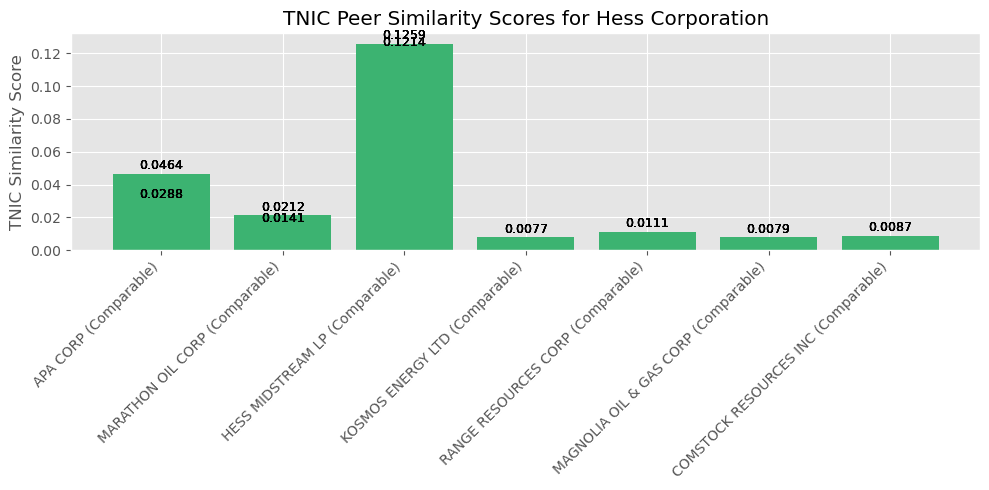

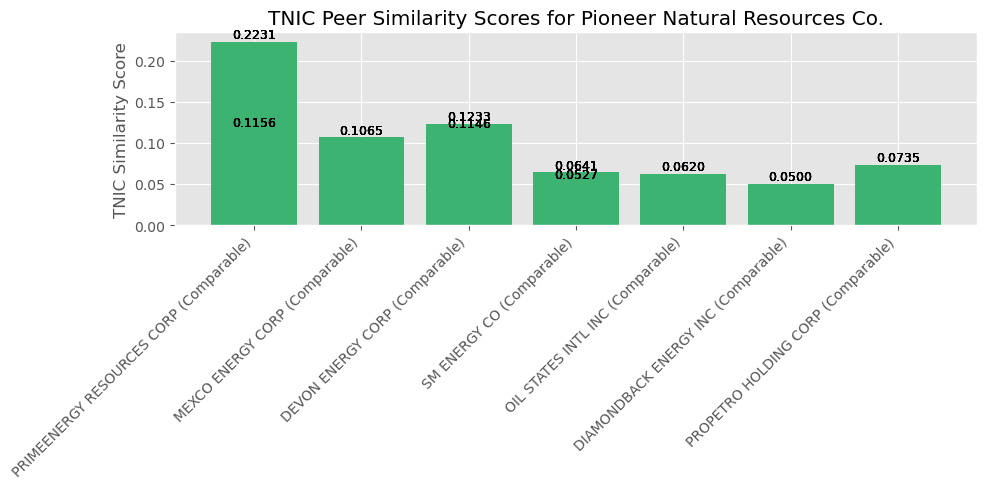

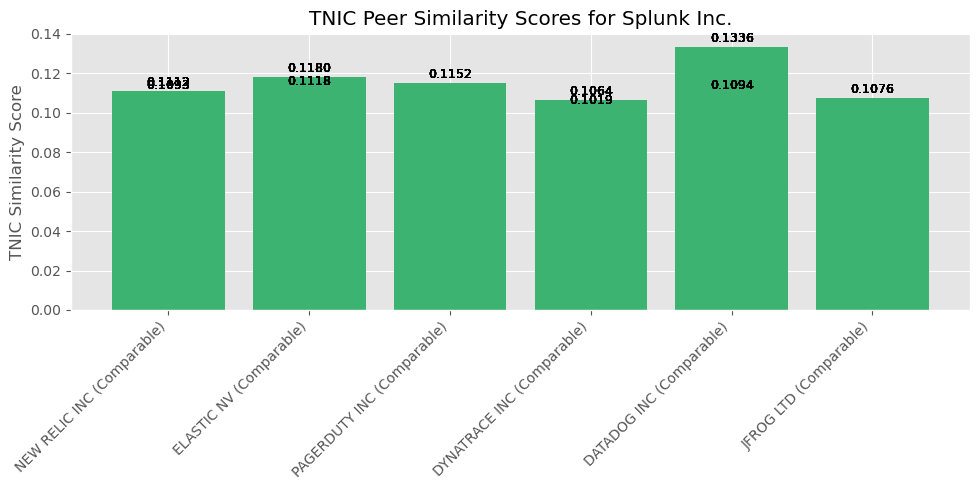

In [279]:
import matplotlib.pyplot as plt

# Ensure score is numeric
top_n_peers['score'] = pd.to_numeric(top_n_peers['score'], errors='coerce')

# Merge target names from top_deals_2023
peer_merged = pd.merge(
    top_n_peers,
    top_deals_2023[['target_name', 'target_ticker']],
    left_on='firm_ticker',
    right_on='target_ticker',
    how='left'
)

# Drop rows with missing info
peer_merged = peer_merged.dropna(subset=['score', 'peer_name', 'target_name'])

# Plot for each acquisition target
for target in peer_merged['target_name'].unique():
    subset = peer_merged[peer_merged['target_name'] == target]
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(subset['peer_name'] + ' (Comparable)', 
                   subset['score'],
                   color='mediumseagreen')
    
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('TNIC Similarity Score')
    plt.title(f'TNIC Peer Similarity Scores for {target}')
    plt.tight_layout()
    
    # Annotate each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', 
                 ha='center', va='bottom', fontsize=9)
    
    plt.show()



#  Peer Companies vs. Fairness Opinions

This section compares the comparable companies disclosed in **Fairness Opinions (F.O.)** for major 2023 acquisitions to the top peer firms identified by the **Textual Network Industry Classification (TNIC)** system. The analysis focuses on four of the largest U.S. deals of the year:

---

##  Pioneer Acquired by Exxon Mobil (PXD → XOM)

- **Fairness Opinion (F.O.) Comparables**: 6  
- **TNIC Top Peers**: 10  
- **Overlapping Companies**:
  -  APA Corporation (APA)  
  -  Devon Energy Corporation (DVN)  

🔍 *Moderate overlap.* The F.O. list omits several high-ranking TNIC peers such as PNRG, SM, and FANG.

---

##  Hess Acquired by Chevron (HES → CVX)

- **Fairness Opinion (F.O.) Comparables**: 6  
- **TNIC Top Peers**: 10  
- **Overlapping Companies**:
  -  APA Corporation (APA)  
  -  Marathon Oil Corporation (MRO)  

 *Moderate overlap.* Several large-cap peers like COP, OXY, and EOG appear only in the F.O. list, while smaller-cap TNIC peers such as KOS, RRC, and HESM are absent from the opinion.

---

##  Splunk Acquired by Cisco (SPLK → CSCO)

- **Fairness Opinion (F.O.) Comparables**: 7  
- **TNIC Top Peers**: 8  
- **Overlapping Companies**:
  -  Dynatrace (DT)  
  -  Datadog (DDOG)  

*Low overlap.* Despite many well-known SaaS names appearing in the F.O. (e.g., Adobe, Atlassian, Workday), only two match TNIC's algorithmic peer set, which leans more toward next-gen observability firms.

---

##  Albertsons Acquired by Kroger (ACI → KR)

- **Fairness Opinion (F.O.) Comparables**: 4  
- **TNIC Top Peers**: 5  
- **Overlapping Companies**:
  -  Ingles Markets Inc. (IMKTA)  
  - Sprouts Farmers Market (SFM)  
  -  Village Super Market (VLGEA)  

 *High overlap.* Near-identical lists suggest strong alignment between market-based TNIC rankings and the F.O. methodology for this transaction.

---

### Conclusion

While some overlap exists, especially for **Albertsons-Kroger**, the overall pattern reveals significant divergence between the **quantitative TNIC rankings** and the **qualitative selections disclosed in fairness opinions**. The TNIC methodology often identifies lesser-known but closely connected firms based on textual similarity and network proximity, whereas fairness opinions tend to emphasize industry-recognized or size-comparable names.

These results raise questions about **potential biases** in peer selection for valuation purposes — especially in tech and energy deals — and underscore the value of supplementing fairness opinions with **objective peer selection frameworks**.
